In [20]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE

paths = {
    'Teacher': '../data/model_weights/deit_s_cifar10_aug.pt',
    'Teacher_EMA': '../data/model_weights/deit_s_cifar10_aug_ema.pt',
    'Student_Full': '../data/model_weights/deit_tiny_full_distilled.pt',
    'Student_Full_EMA': '../data/model_weights/deit_tiny_full_distilled_ema.pt',
    # 'Student_LowRank': '../data/model_weights/deit_tiny_low_rank.pt',  # Исключено!
    # 'Student_LowRank_EMA': '../data/model_weights/deit_tiny_low_rank_ema.pt',  # Исключено!
}

images, labels = torch.load('../data/cifar10_cutmix.pt')
images = images[:1000]
labels = labels[:1000]


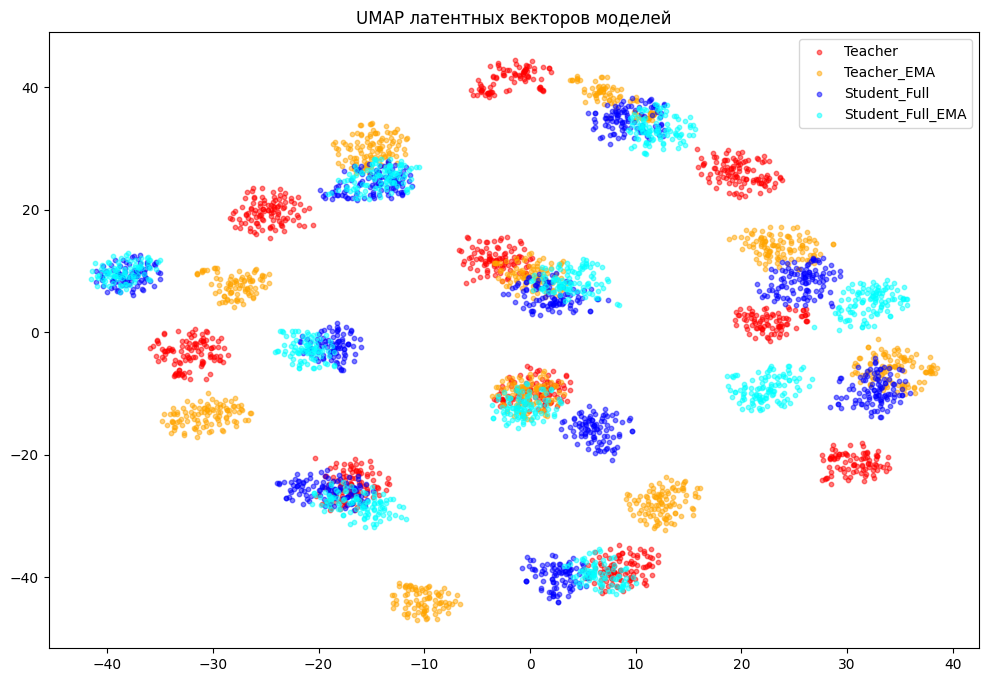

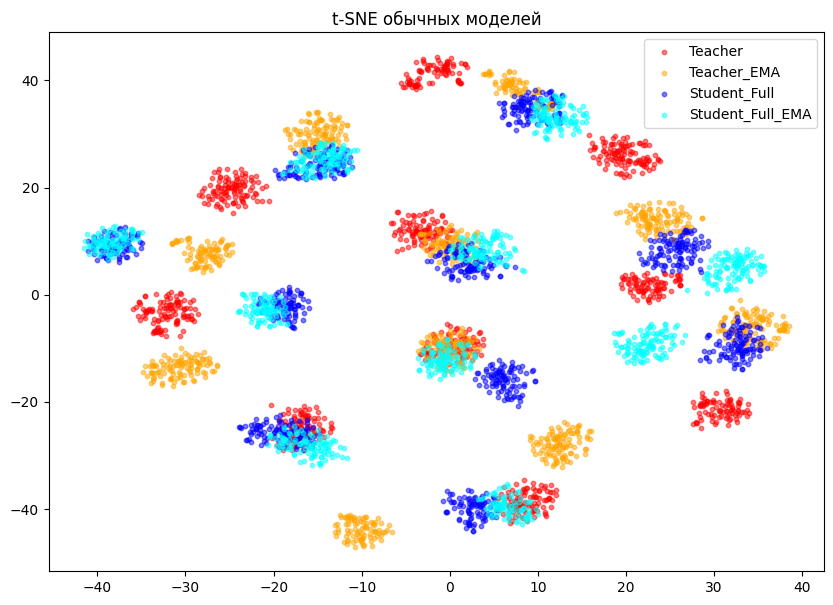

In [21]:
@torch.no_grad()
def get_latents(model, images, device):
    model.eval()
    images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
    images = images.to(device)
    feats = model.forward_features(images)
    if isinstance(feats, (tuple, list)):
        feats = feats[0]
    return feats.cpu().numpy()

latents = {}

for name, path in paths.items():
    if 'Teacher' in name:
        model = timm.create_model('deit_small_patch16_224', pretrained=False, num_classes=10)
    else:
        model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
    state_dict = torch.load(path, map_location='cpu')
    model.load_state_dict(state_dict)
    latents[name] = get_latents(model, images, device='cpu')


plt.figure(figsize=(12, 8))
colors = {
    'Teacher': 'red',
    'Teacher_EMA': 'orange',
    'Student_Full': 'blue',
    'Student_Full_EMA': 'cyan',
    # 'Student_LowRank': 'green',
    # 'Student_LowRank_EMA': 'lime',
}
tsne = TSNE(n_components=2, random_state=42)
for name, vecs in latents.items():
    emb = tsne.fit_transform(vecs[:, 0, :])  # Используем CLS-токен
    plt.scatter(emb[:,0], emb[:,1], label=name, alpha=0.5, s=10, color=colors.get(name, None))
plt.legend()
plt.title('UMAP латентных векторов моделей')
plt.show()


normal_paths = {
    'Teacher': '../data/model_weights/deit_s_cifar10_aug.pt',
    'Teacher_EMA': '../data/model_weights/deit_s_cifar10_aug_ema.pt',
    'Student_Full': '../data/model_weights/deit_tiny_full_distilled.pt',
    'Student_Full_EMA': '../data/model_weights/deit_tiny_full_distilled_ema.pt',
}
latents_normal = {}
for name, path in normal_paths.items():
    if 'Teacher' in name:
        model = timm.create_model('deit_small_patch16_224', pretrained=False, num_classes=10)
    else:
        model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
    state_dict = torch.load(path, map_location='cpu')
    model.load_state_dict(state_dict)
    latents_normal[name] = get_latents(model, images, device='cpu')
plt.figure(figsize=(10, 7))
colors_normal = {
    'Teacher': 'red',
    'Teacher_EMA': 'orange',
    'Student_Full': 'blue',
    'Student_Full_EMA': 'cyan',
}
tsne = TSNE(n_components=2, random_state=42)
for name, vecs in latents_normal.items():
    emb = tsne.fit_transform(vecs[:, 0, :])  # Используем CLS-токен
    plt.scatter(emb[:,0], emb[:,1], label=name, alpha=0.5, s=10, color=colors_normal.get(name, None))
plt.legend()
plt.title('t-SNE обычных моделей')
plt.show()


Replaced 37 layers, skipped 12
Replaced 37 layers, skipped 12


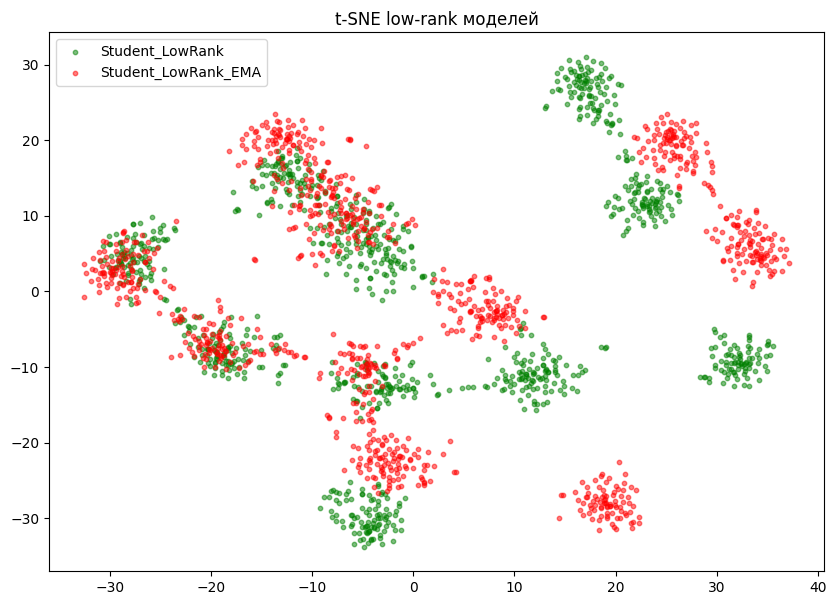

In [25]:
from experiments.low_rank_utils import create_low_rank_model
lowrank_paths = {
    'Student_LowRank': '../data/model_weights/deit_tiny_low_rank.pt',
    'Student_LowRank_EMA': '../data/model_weights/deit_tiny_low_rank_ema.pt',
}
latents_lowrank = {}
for name, path in lowrank_paths.items():

    base_model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=10)
    model = create_low_rank_model(base_model, rank_factor=4)
    state_dict = torch.load(path, map_location='cpu')
    model.load_state_dict(state_dict)
    latents_lowrank[name] = get_latents(model, images, device='cpu')
plt.figure(figsize=(10, 7))
colors_lowrank = {
    'Student_LowRank': 'green',
    'Student_LowRank_EMA': 'red',
}
tsne = TSNE(n_components=2, random_state=42)
for name, vecs in latents_lowrank.items():
    emb = tsne.fit_transform(vecs[:, 0, :])
    plt.scatter(emb[:,0], emb[:,1], label=name, alpha=0.5, s=10, color=colors_lowrank.get(name, None))
plt.legend()
plt.title('t-SNE low-rank моделей')
plt.show()
